In [1]:
import sys, os, inspect

sys.path.append('../lib/')
sys.path.append('../sim_lib/')

def ospath(paths):
    if ('win32' in sys.platform):
        if type(paths)==list or type(paths)==tuple:
            paths = [fn.replace('/c/','c:\\').replace('/', '\\') for fn in paths]
        else:
            paths = paths.replace('/c/','c:\\').replace('/', '\\')
        #print(mltd_paths)
    return paths

import numpy as np

import logging
logger = logging.getLogger('stochastic_ir')
hdlr = logging.FileHandler('./stochastic_ir.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

from  matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import datetime
import copy
import pickle

# Surface structure:

import multiprocessing as mp
import ctypes as c
import gc
import importlib


In [2]:
from scipy.stats import norm
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.integrate import simps
from scipy.integrate import cumtrapz
import scipy.interpolate

In [3]:
import json
import calibrator
import interpolator
import surfaces

# Read Implied Vol, correlations, EUR and USD DF curves

In [4]:
MARKETDATA = '../marketdata_JSON_asof_04_30_2020/'
with open(MARKETDATA+'EUR.json', 'r') as f:
    eurdata = json.load(f)
with open(MARKETDATA+'USD.json', 'r') as f:
    usddata = json.load(f)
with open(MARKETDATA+'EURUSD.json', 'r') as f:
    eurusddata = json.load(f)
with open(MARKETDATA+'correlations.json', 'r') as f:
    correlations = json.load(f)

In [5]:
with open(MARKETDATA+'EURUSD_Heston.json', 'r') as f:
    hestondata = json.load(f)
    
heston_kappa_dict = {'times':hestondata['kappa']['times'],
                     'values':hestondata['kappa']['values']}

heston_volofvar_dict = {'times':hestondata['volofvar']['times'],
                        'values':hestondata['volofvar']['values']}

heston_theta_dict = {'times':hestondata['theta']['times'], 
                     'values':hestondata['theta']['values']}
heston_initialvar = hestondata['initialvar']

In [6]:
rho_domestic_base = correlations['USD_EUR']
rho_base_fx = correlations['EUR_EURUSD']
rho_domestic_fx = correlations['USD_EURUSD']

base_ta = eurdata['g1++']['meanrev']['times']
base_a = eurdata['g1++']['meanrev']['values']
base_tvol = eurdata['g1++']['vol']['times']
base_vol = eurdata['g1++']['vol']['values']
base_x0 = eurdata['g1++']['x0']
base_shifttimes = eurdata['g1++']['shift']['times']
base_shiftvalues = eurdata['g1++']['shift']['values']

domestic_ta = usddata['g1++']['meanrev']['times']
domestic_a = usddata['g1++']['meanrev']['values']
domestic_tvol = usddata['g1++']['vol']['times']
domestic_vol = usddata['g1++']['vol']['values']
domestic_x0 = usddata['g1++']['x0']
domestic_shifttimes = usddata['g1++']['shift']['times']
domestic_shiftvalues = usddata['g1++']['shift']['values']

fxvoldata = eurusddata['impliedvol']
spot_FX = eurusddata['spot']

base_dfcurve = interpolator.InterpolatedCurve(eurdata['discount']['times'], 
                                              eurdata['discount']['values'])
dfcurve = interpolator.InterpolatedCurve(usddata['discount']['times'], 
                                         usddata['discount']['values'])

rho_fx_v = hestondata['rho'] #correlations['EURUSD_EURUSDstochvar']
rho_domestic_v = correlations['USD_EURUSDstochvar']
rho_base_v = correlations['EUR_EURUSDstochvar']

In [7]:
correlations

{'USD_EUR': 0.161,
 'USD_EURUSD': 0.166,
 'EUR_EURUSD': 0.551,
 'USD_EURUSDstochvar': -0.2,
 'EUR_EURUSDstochvar': -0.2,
 'EURUSD_EURUSDstochvar': -0.3620005301106583}

# Interpolate Implied Vol

In [8]:
import fxivolinterpolator as fxvol

In [9]:
fxvolsurf = fxvol.FXIVolInterpolator(eurusddata['impliedvol'], eurusddata['spot'], dfcurve, base_dfcurve)

# Setup Calibration local vol spots and times

In [10]:
import StochasticSim_Multiprocessing as simulator

In [11]:
if 'locvol_sim' in locals() or 'locvol_sim' in globals():
    locvol_sim.delete_all()
    del(locvol_sim)
    print('Deleted lvolsim')

In [12]:
nr_mcruns = 100000 ### number of calibration runs
NRSUBSIM = 5  ### number of multiprocessing sub-processes 
LVOL_NUMMETHOD = 'ForwardEuler'
SHORTRATE_NUMMETHOD = 'ForwardEuler'
ANTITHETIC = True

save_output_flags = {'HESTON':True, 'XD': True, 'XB': True}

locvol_sim = simulator.StochasticLocalVolSimulation(
                    domestic_shifttimes, domestic_shiftvalues, base_shifttimes, base_shiftvalues, spot_FX,
                    heston_initialvar, heston_volofvar_dict, heston_kappa_dict, heston_theta_dict,
                    domestic_ta, domestic_a, domestic_tvol, domestic_vol, domestic_x0,
                    base_ta, base_a, base_tvol, base_vol, base_x0,
                    rho_domestic_base, rho_domestic_fx, rho_base_fx,
                    rho_fx_v, rho_domestic_v, rho_base_v,
                    nr_mcruns, LVOL_NUMMETHOD, SHORTRATE_NUMMETHOD,
                    antitheticpaths=ANTITHETIC,
                    in_forward_measure=True,
                    nrsubsim=NRSUBSIM,
                    observation_names=['FXrate', 'FXStochVariance', 'Domestic_XFactor', 'Base_XFactor'],
                    observe_at_given_times=True,
                    domestic_currency_name='USD',
                    base_currency_name='EUR',
                    fx_name='EURUSD',
                    save_output_flags = save_output_flags
                    )

locvol_sim.det_DR = False
locvol_sim.det_FR = False

Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...XS RD RB XD XB 
Allocating shmem ...XS RD RB XD XB 
Allocating shmem ...XS RD RB XD XB 
Allocating shmem ...XS RD RB XD XB 
Allocating shmem ...XS RD RB XD XB 
Initializing pool for ... <class 'StochasticSim_Multiprocessing.StochasticLocalVolSimulation'>


# Read Current Localvol

In [13]:
LVOL_PATH = '../LV_2SIR/output_LV_2SIR/'
LVOL_FILENAME = 'lvolsample_100000_VolInterp.pkl'

with open(ospath(LVOL_PATH + LVOL_FILENAME), 'rb') as f:
    lvoldata = pickle.load(f)
lvol_spots = lvoldata['spots']
lvol_times = lvoldata['times']
lvol_values = lvoldata['surfacevalues']

(21, 100) (21, 100) (21, 100)


Text(0.5, 0.92, 'Local Vol surface')

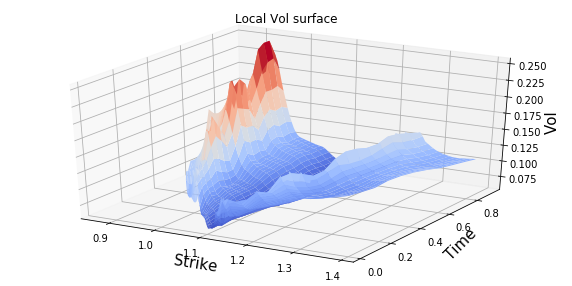

In [14]:
fig = plt.figure(figsize=(10,5))
plotid=1
num_slices=-1
X_lvol = np.array(lvol_spots[:num_slices]) 
Y_lvol = np.array([lvol_times[:num_slices]]*X_lvol.shape[1]).T
Z_lvol = np.array(lvol_values[:num_slices])
print(X_lvol.shape, Y_lvol.shape, Z_lvol.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d')
surf = ax.plot_surface(X_lvol, Y_lvol, Z_lvol, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Vol', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
#ax.set_zlim([-0.05, 0.13])
ax.set_title('Local Vol surface')

In [15]:
LOCALVOL_CAP = 1.0
surface = surfaces.generate_lv_surface_from_values_nonuniform(lvol_spots, lvol_times, lvol_values,
                                                            dfcurve, base_dfcurve, spot_FX,
                                                            LOCALVOL_CAP)

In [16]:
lvol_file_nmc=nr_mcruns
L_FILENAME = 'leverage_sampleFULL_%d.pkl' % (lvol_file_nmc)
OUTPUTDIR = './output_SLV_2SIR/'

In [17]:
VAR_METHOD = 'binning' #'curve_fit' #
locvol_cal = calibrator.StochasticLocalVolStochasticIRCalibration(
                                surface, locvol_sim,
                                var_method=VAR_METHOD,
                                filename=ospath(OUTPUTDIR + L_FILENAME))

In [18]:
leverage_vals = locvol_cal.calibrate_localvol(lvol_spots, lvol_times, lvol_values)

Processing time: 0.020000
0.02 250
ProcessID:0, n_trials:20000, maturity:0.020, timesteps:5
ProcessID:1, n_trials:20000, maturity:0.020, timesteps:5
ProcessID:2, n_trials:20000, maturity:0.020, timesteps:5
ProcessID:3, n_trials:20000, maturity:0.020, timesteps:5
ProcessID:4, n_trials:20000, maturity:0.020, timesteps:5
Written: .\output_SLV_2SIR\leverage_sampleFULL_100000.pkl
Processing time: 0.030000
0.03 250
ProcessID:0, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:1, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:2, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:3, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:4, n_trials:20000, maturity:0.030, timesteps:7
Written: .\output_SLV_2SIR\leverage_sampleFULL_100000.pkl
Processing time: 0.040000
0.04 250
ProcessID:0, n_trials:20000, maturity:0.040, timesteps:10
ProcessID:1, n_trials:20000, maturity:0.040, timesteps:10
ProcessID:2, n_trials:20000, maturity:0.040, timesteps:10
ProcessID:3, n_trials:20000, maturi

Written: .\output_SLV_2SIR\leverage_sampleFULL_100000.pkl
Processing time: 0.800000
0.8 250
ProcessID:0, n_trials:20000, maturity:0.800, timesteps:200
ProcessID:1, n_trials:20000, maturity:0.800, timesteps:200
ProcessID:2, n_trials:20000, maturity:0.800, timesteps:200
ProcessID:3, n_trials:20000, maturity:0.800, timesteps:200
ProcessID:4, n_trials:20000, maturity:0.800, timesteps:200
Written: .\output_SLV_2SIR\leverage_sampleFULL_100000.pkl
Processing time: 0.850000
0.8500000000000001 250
ProcessID:0, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:1, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:2, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:3, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:4, n_trials:20000, maturity:0.850, timesteps:212
Written: .\output_SLV_2SIR\leverage_sampleFULL_100000.pkl
Processing time: 0.900000
0.9000000000000001 250
ProcessID:0, n_trials:20000, maturity:0.900, timesteps:225
ProcessID:1, n_trials:20000, maturity:0.900, 

### Optional Save pkl

In [19]:
l_data = {}
l_data['spots'] = lvol_spots
l_data['times'] = lvol_times
l_data['surfacevalues'] = leverage_vals[1:]

In [20]:
FILENAME = 'leverage_data%d.pkl'%nr_mcruns

with open(OUTPUTDIR+FILENAME, 'wb') as f:
    pickle.dump(l_data, f)

(21, 100) (21, 100) (21, 100)


Text(0.5, 0.92, 'Local Vol surface')

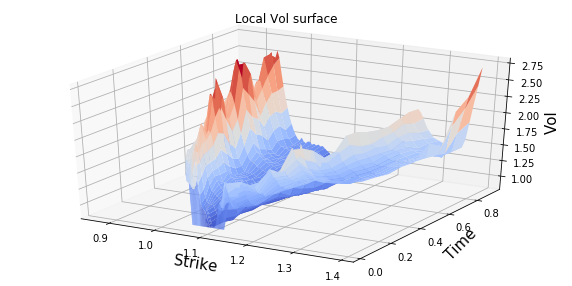

In [20]:
fig = plt.figure(figsize=(10,5))
plotid=1
num_slices=-1
X_lvol = np.array(lvol_spots[:num_slices]) 
Y_lvol = np.array([lvol_times[:num_slices]]*X_lvol.shape[1]).T
Z_lvol = np.array(leverage_vals[:num_slices-1])
print(X_lvol.shape, Y_lvol.shape, Z_lvol.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d') #fig.add_subplot(2, 2, plotid, projection='3d')
surf = ax.plot_surface(X_lvol, Y_lvol, Z_lvol, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Vol', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
#ax.set_zlim([-0.05, 0.13])
ax.set_title('Local Vol surface')